# Garbage Classification with MobileNetV2

## Import libraries

In [36]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow as tf
import re
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, Dense
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image

print('Setup successful!')

Setup successful!


## Set up constaints

In [37]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Path where our data is located
base_path = "./garbage_classification/"

# Dictionary to save our 12 classes
categories = {
    0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash',
    5: 'battery', 6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass',
    10: 'white-glass', 11: 'biological'
}

print('Defining constants successful!')

Defining constants successful!


## Dataframe setup

Create a dataframe to organize the filename and category data with two columns, 'filename' and 'category,' where 'filename' contains the modified image file paths (with class prefixes added) and 'category' contains the class labels. Finally, shuffle this dataframe to prevent data ordering bias.

In [38]:
# Add class name prefix to filename, so "/paper104.jpg" becomes "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d", x).start()] + '/' + x)
    return df

def mobilenetv2_preprocessing(img):
    return tf.keras.applications.mobilenet_v2.preprocess_input(img)

# List containing all the filenames in the dataset
filenames_list = []
# List to store the corresponding category; note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('Number of elements =', len(df))

Number of elements = 15515


In [39]:
df.head()

,filename,category
0,green-glass/green-glass290.jpg,8
1,paper/paper605.jpg,0
2,trash/trash275.jpg,4
3,white-glass/white-glass5.jpg,10
4,brown-glass/brown-glass56.jpg,9


clothes/clothes5063.jpg


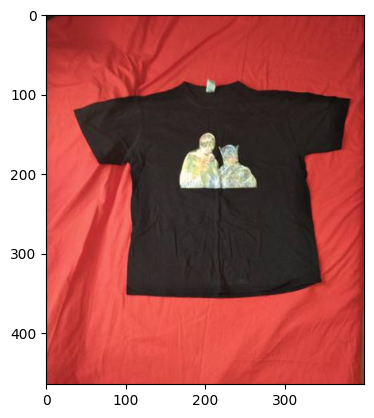

In [40]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

## Visualize data distribution

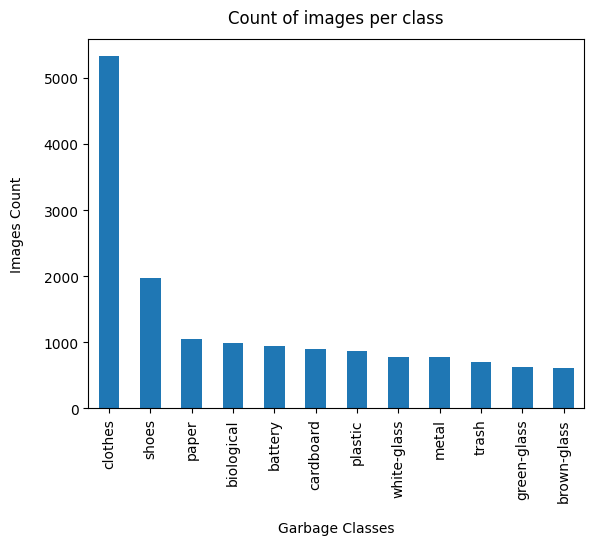

In [41]:
df_visualization = df.copy()
# Change the categories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [42]:
mobilenetv2_layer = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    weights='imagenet',
    pooling='avg'
)

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False

# Create a custom layer to apply preprocessing
def mobilenetv2_preprocessing(img):
    return tf.keras.applications.mobilenet_v2.preprocess_input(img)

model_input = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
x = Lambda(mobilenetv2_preprocessing)(model_input)
x = mobilenetv2_layer(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=model_input, outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

early_stop = EarlyStopping(patience=2, verbose=1, monitor='val_categorical_accuracy', mode='max', min_delta=0.001,
                           restore_best_weights=True)

callbacks = [early_stop]

print('Callback defined!')

# Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# Split the data into train, validation, and test sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('Train size =', total_train, 'Validate size =', total_validate, 'Test size =', test_df.shape[0])

batch_size = 64

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 lambda_7 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_6 (Dense)             (None, 12)                15372     
                                                                 
Total params: 2273356 (8.67 MB)
Trainable params: 15372 (60.05 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Callback defined!
Train size = 12412 Validate size = 1551 Test size = 1552


In [43]:
# Create data pipelines using tf.data API
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_validate // batch_size,
    callbacks=callbacks
)

model.save("model.keras")

Found 12412 validated image filenames belonging to 12 classes.
Found 1551 validated image filenames belonging to 12 classes.
Epoch 1/20
193/193 [==============================] - 163s 835ms/step - loss: 0.7155 - categorical_accuracy: 0.7920 - val_loss: 0.2959 - val_categorical_accuracy: 0.9271
Epoch 2/20
193/193 [==============================] - 133s 686ms/step - loss: 0.3434 - categorical_accuracy: 0.8944 - val_loss: 0.2394 - val_categorical_accuracy: 0.9349
Epoch 3/20
193/193 [==============================] - 123s 638ms/step - loss: 0.2959 - categorical_accuracy: 0.9082 - val_loss: 0.2235 - val_categorical_accuracy: 0.9453
Epoch 4/20
193/193 [==============================] - 122s 631ms/step - loss: 0.2714 - categorical_accuracy: 0.9161 - val_loss: 0.2135 - val_categorical_accuracy: 0.9395
Epoch 5/20
193/193 [==============================] - 132s 682ms/step - loss: 0.2579 - categorical_accuracy: 0.9176 - val_loss: 0.2105 - val_categorical_accuracy: 0.9421
Epoch 5: early stopping


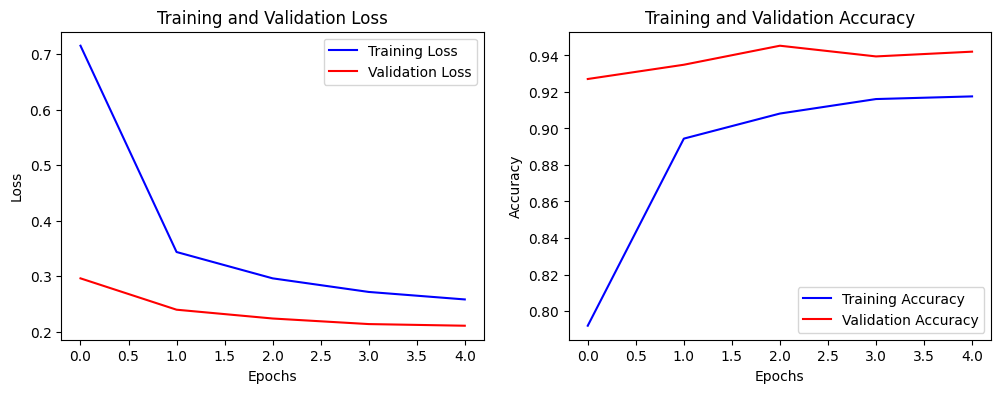

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()

In [45]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Accuracy on test set =', round((accuracy * 100), 2), '%')

Found 1552 validated image filenames belonging to 12 classes.
1552/1552 [==============================] - 36s 23ms/step - loss: 0.2466 - categorical_accuracy: 0.9291
Accuracy on test set = 92.91 %


In [46]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated its own dictionary and it has assigned different numbers to our categories, and the predictions made by the model
# will be made using the generator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v, k) for k, v in gen_label_map.items())
print(gen_label_map)

# Get the model's predictions for the test set
preds = model.predict(test_generator, steps=nb_samples)

# Get the category with the highest predicted probability; the prediction is only the category's number and not the name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas DataFrame to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}
1552/1552 [==============================] - 36s 23ms/step
              precision    recall  f1-score   support

     battery       0.94      0.99      0.96        80
  biological       0.96      0.96      0.96       108
 brown-glass       0.92      0.88      0.90        69
   cardboard       0.96      0.87      0.91        86
     clothes       0.98      0.99      0.99       522
 green-glass       0.94      0.82      0.88        62
       metal       0.78      0.86      0.82        84
       paper       0.89      0.91      0.90       112
     plastic       0.81      0.81      0.81        97
       shoes       0.94      0.99      0.96       177
       trash       0.94      0.90      0.92        67
 white-glass       0.82      0.75      0.79        88

    accuracy                           0.93      1552
   